<a href="https://colab.research.google.com/github/CaptaiN785/Face-expression-recognition/blob/main/facial_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import zipfile
import os

import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers

In [6]:
file = zipfile.ZipFile('data.zip')
file.extractall()
file.close()

In [11]:
training_path = 'images/train'
validation_path = 'images/validation'

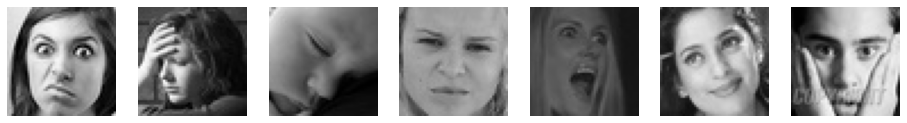

Image shape:  (48, 48, 3)
Total training images:  28821
Total validation image:  7066


In [25]:
## Printing the image from each expression
plt.figure(figsize= (16, 8))
shape = None
total_size = 0
for i, file_name in enumerate(os.listdir(training_path)):
    plt.subplot(1, 7, i+1)
    image_path = os.listdir(os.path.join(training_path, file_name))
    total_size += len(image_path)
    img = cv.imread(training_path + '/'+file_name+'/'+image_path[0])
    plt.imshow(img)
    shape = img.shape
    plt.axis('off')
plt.show()

total_val_size = 0
for i, file_name in enumerate(os.listdir(validation_path)):
    image_path = os.listdir(os.path.join(validation_path, file_name))
    total_val_size += len(image_path)

print("Image shape: ", shape)
print("Total training images: ", total_size)
print("Total validation image: ", total_val_size)

In [23]:
## Image generator

train_gen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip = True,
    rescale = 1.0/255.0
)

test_gen = ImageDataGenerator(rescale = 1.0/255.0)

In [29]:
## Fetching the image from the directory using image data generator

batch_size = 64
steps = np.ceil(total_size/batch_size)

train = train_gen.flow_from_directory(
    training_path, 
    target_size = (48, 48),
    batch_size = batch_size,
)

val_steps = np.ceil(total_val_size/batch_size)
test = test_gen.flow_from_directory(
    validation_path,
    target_size = (48, 48),
    batch_size = batch_size,
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [38]:
model = models.Sequential([
    layers.Conv2D(128, (5, 5), strides = (2, 2), activation='relu', padding='same', input_shape= (48, 48, 3)),
    layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(7, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 24, 24, 128)       9728      
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 128)       147584    
                                                                 
 batch_normalization_3 (Batc  (None, 24, 24, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 128)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 12, 12, 256)      

In [39]:
history = model.fit(train,
          epochs = 50,
          steps_per_epoch=steps,
          validation_steps = val_steps,
          validation_data=test)

Epoch 1/50
451/451 [==============================] - 40s 88ms/step - loss: 1.9350 - accuracy: 0.2366 - val_loss: 1.8273 - val_accuracy: 0.2635
Epoch 2/50
451/451 [==============================] - 38s 85ms/step - loss: 1.7948 - accuracy: 0.2537 - val_loss: 1.8777 - val_accuracy: 0.2576
Epoch 3/50
451/451 [==============================] - 38s 85ms/step - loss: 1.7905 - accuracy: 0.2531 - val_loss: 1.9052 - val_accuracy: 0.2447
Epoch 4/50
451/451 [==============================] - 39s 86ms/step - loss: 1.7840 - accuracy: 0.2564 - val_loss: 2.0450 - val_accuracy: 0.2304
Epoch 5/50
451/451 [==============================] - 38s 84ms/step - loss: 1.7611 - accuracy: 0.2737 - val_loss: 2.0103 - val_accuracy: 0.2559
Epoch 6/50
451/451 [==============================] - 39s 87ms/step - loss: 1.6954 - accuracy: 0.3148 - val_loss: 1.6180 - val_accuracy: 0.3565
Epoch 7/50
451/451 [==============================] - 38s 84ms/step - loss: 1.5996 - accuracy: 0.3583 - val_loss: 1.5335 - val_accuracy: